# TCGA dataset exploratory data analysis

The data is downloaded from TCGA database (https://portal.gdc.cancer.gov/).

In [14]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

AUGMENTATION = 0

# Specify the path to the parent directory containing the folders to iterate through
parent_dir = "../data/data-tcga/samples"
sample_sheet_file = "../data/data-tcga/gdc_sample_sheet.2023-05-20.tsv"
clinical_file = "../data/data-tcga/clinical.tsv"

all_data_file_path = "all_data_geo.pkl"
all_labels_file_path = "all_labels_geo.pkl"
all_data_columns_file_path = "all_data_columns.pkl"
ignored_tissues_file_path = "ignored_tissues_list_geo.pkl"
class_mapping_file_path = "class_mapping_geo.pkl"
encoder_file = f"encoder_{AUGMENTATION}.pkl"
model_file_name = f"nn-{AUGMENTATION}.model"

In [2]:
# class mapping
class_mapping = {}
# ignore unknown tissues
ignored_tissues = []

# load the files if they exist

if os.path.exists(class_mapping_file_path):

    # load the list of ignored tissues from a pickel file
    with open(ignored_tissues_file_path, 'rb') as f: 
        ignored_tissues = pickle.load(f)

    # load a dataframe with the labels of each sample from a pickel file
    with open(class_mapping_file_path, 'rb') as f: 
        class_mapping = pickle.load(f)

In [3]:
# verify if the all_data_file_path exist or not
if not os.path.exists(all_data_file_path):
    
    # read sample sheet file and clinical file into the memory
    sample_sheet = pd.read_csv(sample_sheet_file, delimiter="\t")
    clinical_sheet = pd.read_csv(clinical_file, delimiter="\t")
    
    all_data = []
    all_labels = []

    # Iterate through all folders in the parent directory
    for folder in os.listdir(parent_dir):
        # Create the full path to the folder
        folder_path = os.path.join(parent_dir, folder)
        # Check if the item in the directory is a folder
        if os.path.isdir(folder_path):

            # try to extract the cancer tissue first, if possible
            row = sample_sheet[ sample_sheet['File ID'] == folder ]
            
            # confirm that there is at most 1 row extracted for the current folder
            assert(row.shape[0] < 2)

            # access the value stored in Case ID
            case_id = row['Case ID'].values[0]

            case_id_clinical = clinical_sheet[clinical_sheet['case_submitter_id'] == case_id]
            if len(case_id_clinical['tissue_or_organ_of_origin'].values) == 0:
                continue

            tissue_organ_origin = case_id_clinical['tissue_or_organ_of_origin'].values[0]

            # skipping the labels stored in ignored_tissue list:
            if tissue_organ_origin in ignored_tissues:
                continue

            # storing the labels in a dictionary
            if tissue_organ_origin not in class_mapping:
                new_label = None
                # try to find an already seen label in tissue_organ_origin automatically
                for label in all_labels:
                    # converting label from dataframe to string
                    label = label[0][0]
                    if label in tissue_organ_origin.lower():
                        new_label = label
                        break
                # manual user input required to determine the label
                if new_label is None:
                    print(f'New tissue origin found: \"{tissue_organ_origin}\". \nEnter the label for it or leave it empty to add it to the ignore list: ')
                    new_label = input()

                    if new_label == "":
                        ignored_tissues.append(tissue_organ_origin)
                        continue
                class_mapping[tissue_organ_origin] = new_label

            # tissue extracted successfully!
            all_labels.append(pd.DataFrame([class_mapping[tissue_organ_origin]]))


            # extract the gene counts

            # Get a list of all .tsv files in the folder
            tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]
            # If there is exactly one .tsv file in the folder, proceed
            if len(tsv_files) == 1:
                # Create the full path to the .tsv file
                tsv_path = os.path.join(folder_path, tsv_files[0])
                
                # Open the .tsv file and count the number of lines starting with "ENSG"
                columns = []
                counts = []
                with open(tsv_path, 'r') as tsv_file:
                    for line in tsv_file:
                        if line.startswith("ENSG"):

                            split_line = line.split('\t')

                            gene_name = split_line[1]
                            tpm = split_line[6]
                            columns.append(gene_name)
                            counts.append(tpm)

                row_df = pd.DataFrame(counts, dtype=np.float32)
                all_data.append(row_df)

    print("Tissue and counts extracted sucessfully!")

    all_data = pd.concat(all_data, axis=1, ignore_index=True).transpose()
    all_data.columns = columns
    all_labels = pd.concat(all_labels, axis=0, ignore_index=True)

    # store the count matrices and labels into pickle files
    with open(all_data_file_path, 'wb') as all_data_pckl:
        pickle.dump(all_data, all_data_pckl)
    with open(all_labels_file_path, 'wb') as all_labels_pckl:
        pickle.dump(all_labels, all_labels_pckl)
    

else: # .pkl file exists, load everything from it to skip processing

    with open(all_data_file_path, 'rb') as all_data_pckl:
        all_data = pickle.load(all_data_pckl)
    with open(all_labels_file_path, 'rb') as all_labels_pckl:
        all_labels = pickle.load(all_labels_pckl)

In [4]:
# save the files if they do not exist
if not os.path.exists(class_mapping_file_path):
    
    # save the list of ignored tissues in a pickel file
    with open(ignored_tissues_file_path, 'wb') as f: 
        pickle.dump(ignored_tissues, f)

    # save a dataframe with the labels of each sample in a pickel file
    with open(class_mapping_file_path, 'wb') as f: 
        pickle.dump(class_mapping, f)

In [5]:
# save the all_data columns in a list
all_data_columns = all_data.columns
print("all_data_columns: ", all_data_columns)
print(f'Total gene count: {len(all_data_columns)}')
unique_columns = list(set(all_data_columns))
print(f'Unique gene count: {len(unique_columns)}')

# save the columns to use it later to organize the columns of different dataset
with open(all_data_columns_file_path, 'wb') as all_data_columns_pckl: 
    pickle.dump(unique_columns, all_data_columns_pckl)

all_data_columns:  Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'AL451106.1', 'AC092910.4', 'AC073611.1', 'AC136977.1', 'AC078856.1',
       'AC008763.4', 'AL592295.6', 'AC006486.3', 'AL391628.1', 'AP006621.6'],
      dtype='object', length=60660)
Total gene count: 60660
Unique gene count: 59427


The column names are genes as expected, the problem now is that we have duplicated columns and xgboost will complain. The solution will be adding the counts of columns with the same gene name.

In [6]:
all_data_unique = all_data.groupby(all_data.columns, axis=1).sum()
print(f'Total gene count: {len(all_data_unique.columns)}')
unique_columns = len(set(all_data_unique.columns))
print(f'Unique gene count: {unique_columns}')
del all_data

Total gene count: 59427
Unique gene count: 59427


Now we are ready to train, since all columns have a unique name

**Training xgBoost Model**

In [7]:
import pandas as pd
import numpy as np
import pickle
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from dataset import loadDataset, createBatches
from model import Model

import logging
import tensorflow as tf

2023-06-17 17:53:06.311257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 17:53:07.343776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
# Data augmentation

random_percentage = AUGMENTATION / 100.0

all_data_augmented = all_data_unique
all_labels_augmented = all_labels 

if random_percentage != 0:
    # set the seed for reproducibility
    np.random.seed(42)

    # mask is multiplicative:
    #   - wherever there is 1 the original number doesn't change
    #   - wherever there is 0 the original number is "deleted" by being set to zero
    
    # copy all_data dataset

    all_data_copy = all_data_unique.copy()
    # print("Initial data matrix copy BEFORE augmentation:")
    # print(all_data_copy)
    
    zero_out_mask = np.random.rand(all_data_copy.shape[0], all_data_copy.shape[1])
    # print("Original float random mask matrix:")
    # print(zero_out_mask)
    zero_out_mask[ zero_out_mask > random_percentage ] = 1
    zero_out_mask[ zero_out_mask <= random_percentage ] = 0
    # print("Final boolean random matrix:")
    # print(zero_out_mask)

    all_data_copy = all_data_copy * zero_out_mask
    del zero_out_mask
    # print("Final data matrix copy AFTER augmentation:")
    # print(all_data_copy)

    # all_data_augmented = all_data_copy
    # all_labels_augmented = all_labels

    all_data_augmented = pd.concat([all_data_unique, all_data_copy], axis = 0)
    print("Shape of all_data_augmented dataset: ", all_data_augmented.shape)

    all_labels_augmented = pd.concat([all_labels, all_labels], axis = 0)
    print("Shape of all_labels_augmented dataset: ", all_labels_augmented.shape)

    del all_data_copy
    


Shape of all_data_augmented dataset:  (17336, 59427)
Shape of all_labels_augmented dataset:  (17336, 1)


In [9]:
# Free up memory before training
del all_data_unique
del all_labels
# del clinical_sheet
del class_mapping
del ignored_tissues

In [10]:
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels_augmented[0].to_list())
del all_labels_augmented

In [11]:
# neural network parameters

# Percent of samples to be used for validation (Range: 0 - 1)
validationSplit = 0.2

# A list in which each integer represents the number of nodes in that hidden layer. 
# Number of hidden layers depends on the number of elements in the list (a larger model 
# can learn a more complex representation of the training data, thereby possibly 
# increasing accuracy, but is more prone to overfit and needs longer to train)
hiddenLayers = [256, 128]

# The learning rate applied to the optimizer (a lower value will make each update 
# step smaller, which will slow down training, but could increase accuracy)
learningRate = 0.01

# Number of runs the model will make through the dataset before stopping
epochs = 5

# Display current metrics every displayStep epochs, 
# e.g. if 5 the metrics will be displayed on epoch 5, 10, 15...
displayStep = 1

# Number of samples per batch
batchSize = 512

# Maximum sample capacity for the shuffling buffer used during training 
# (a higher value can impove accuracy, but makes the shuffling take more time)
bufferSize = 1024

# The activation function used in the hidden layers of the prediction network. 
# Possible functions: \"relu\" (only positive tensors pass, negative tensors become 0), 
# \"tanh\" (tensors get squished between -1 and 1), \"sigmoid\" (tensors get squished between 
# 0 and 1), \"linear\" (no actiavtion, i.e. x = x, hidden layers have no effect with this function)
activationFunc = "tanh"

# Wheather to use batch normalization (batch norm) between the prediction layers. 
# Batch normalization applies a transformation that maintains the mean output close to 0 
# and the output standard deviation close to 1 (depending on the data this could imporve 
# training performance, make training faster and slightly reduce overfitting)
batchNorm = True

# The seed that will be used for random processes such as parameter initialization and shuffling 
# between epochs (this allows for reproducible results by making randomization deterministic)
seed = 42

# L0 regularization parameter (a higher value can reduce overfitting, 
# but risks weakening the model)
lZeroLambda = 0.2

In [12]:
# create the TensorFlow dynamic dataset loader
def one_hot(x, n_labels):
    enc = [0] * n_labels
    enc[x] = 1
    return enc

all_labels_one_hot = [ one_hot(x, len(label_encoder.classes_)) for x in all_labels_encoded ]
dataset = loadDataset(all_data_augmented, all_labels_one_hot, label_encoder.classes_)
trainData, trainBatches, testData, testBatches = createBatches(
    dataset,
    all_data_augmented.shape[0],
    validationSplit,
    bufferSize,
    batchSize
)
num_samples = all_data_augmented.shape[0]
num_features = all_data_augmented.shape[1]

2023-06-17 17:53:41.451381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-17 17:53:41.607250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-17 17:53:41.607513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
# del all_data_augmented
# del all_labels_encoded
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
modelParams = {
    "input_node": num_features,
    "hidden_layers_node": hiddenLayers,
    "output_node": len(label_encoder.classes_),
    "feature_selection": True,
    "batch_normalization": batchNorm,
    "activation_pred": activationFunc,
    "activation_gating": "tanh",
    "gating_net_hidden_layers_node": [10],
    "display_step": displayStep,
    "seed": seed,
    "lam": lZeroLambda
}

# with tf.device('/GPU:0'):
model = Model(**modelParams)

logging.info(">> Starting training")

# start = time.time()
train_losses, train_accs, val_losses, val_accs = model.train(trainData, testData, trainBatches, testBatches, epochs, learningRate)
# trainTime = time.time() - start

# yPred, yTest = model.test(testData, testBatches)
# zPred, yTrain = model.test(trainData, trainBatches)

# accuracy = accuracy_score(yTest, yPred)


print("Done.")

2023-06-17 17:31:58.423955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-17 17:31:58.424264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-17 17:32:05.534797: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f072c5a3f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-17 17:32:05.534847: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7

>> [LSPIN] Epoch: 1| Train [loss: 0.6602, acc: 84.17%] - Test [loss: 0.6283, acc: 84.60%]
>> [LSPIN] Epoch: 2| Train [loss: 0.4065, acc: 91.70%] - Test [loss: 0.3876, acc: 91.78%]
>> [LSPIN] Epoch: 3| Train [loss: 0.3157, acc: 94.60%] - Test [loss: 0.2812, acc: 95.53%]
>> [LSPIN] Epoch: 4| Train [loss: 0.3076, acc: 94.44%] - Test [loss: 0.2767, acc: 95.70%]
>> [LSPIN] Epoch: 5| Train [loss: 0.2164, acc: 97.10%] - Test [loss: 0.2081, acc: 97.23%]
Done.


In [15]:
#saving the model for later use
with open(model_file_name, 'wb') as file_model:
    pickle.dump(model, file_model)

In [15]:
#load the model
with open(model_file_name, 'rb') as f:
    model = pickle.load(f)

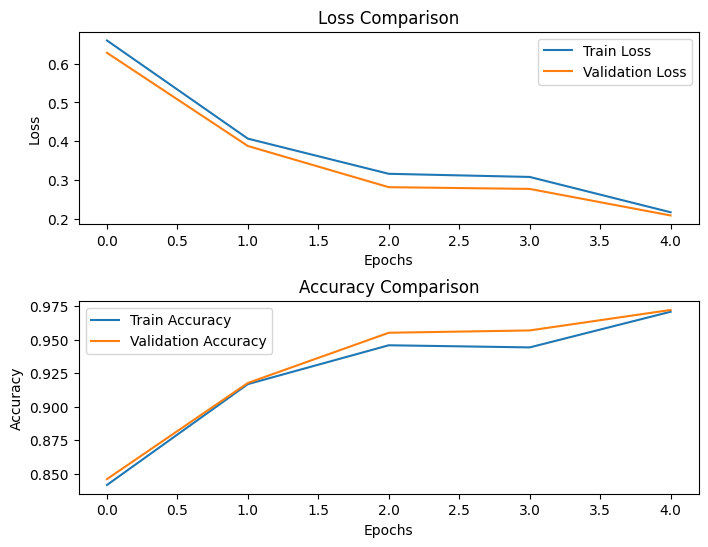

In [17]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot losses
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Comparison')
ax1.legend()

# Plot accuracies
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Comparison')
ax2.legend()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the figure
plt.show()

2023-06-17 17:54:08.943996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


tf.Tensor([8 0 8 ... 6 1 2], shape=(3468,), dtype=int64)


2023-06-17 17:55:35.222195: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1648742688 exceeds 10% of free system memory.


109/109 [==============================] - 2s 8ms/step


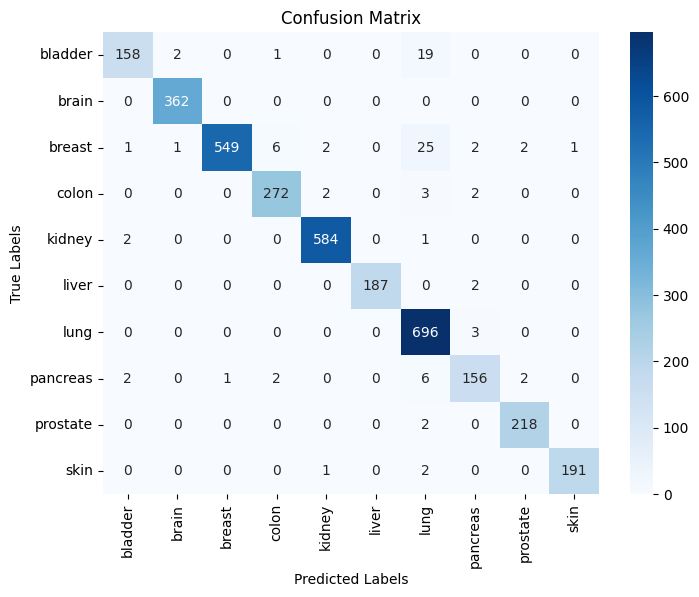

In [16]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix

# del trainBatches, testBatches

# Assuming `test_labels` contains the true class labels for the test set
test_labels = tf.argmax(tf.concat([data['labels'] for i, data in enumerate(testData)], 0), 1)
print(test_labels)

# Assuming the model is already trained and stored the predictions in `test_predictions`
test_data_evaluated = tf.concat([data['features'] for i, data in enumerate(testData)], 0)
test_predictions = model.predict(test_data_evaluated)
test_predictions = np.argmax(test_predictions, axis=1)

# Assuming `label_encoder` contains the label encoder used during training
label_names = label_encoder.classes_
confusion_mat = confusion_matrix(test_labels, test_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#saving the label encoder for later use
with open(encoder_file, 'wb') as f:
    pickle.dump(label_encoder, f)

In [ ]:
# print("Verifying accuracy...")
# # verify accuracy of the train data
# pred_train = model_train.predict(all_data_train)

# accuracy = accuracy_score(pred_train, all_labels_encoded_train)
# print("Accuracy of the train: %.4f%%" % (accuracy * 100.0))

# # verify accuracy of the validation data
# pred_validation = model_train.predict(all_data_validation)

# accuracy = accuracy_score(pred_validation, all_labels_encoded_validation)
# print("Accuracy of the validation: %.4f%%" % (accuracy * 100.0))

# print(label_encoder.classes_)
# confusion = sklearn.metrics.confusion_matrix(all_labels_encoded_validation, pred_validation)
# print(confusion)

# # Plotting the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
#             xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

test_labels = test_labels.numpy()
accuracy = sum(test_predictions == test_labels) / float(len(test_predictions))
print("Accuracy of the test: %.4f%%" % (accuracy * 100.0))

# Calculate precision
precision = precision_score(test_labels, test_predictions, average='macro')

# Calculate recall
recall = recall_score(test_labels, test_predictions, average='macro')

# Calculate F1 score
f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Accuracy of the test: 97.2607%
Precision: 0.9764
Recall: 0.9663
F1 Score: 0.9709
